In [35]:
from __future__ import print_function, division
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import thinkstats2
import thinkplot
import hypothesis
import regression
import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings("ignore")

##                             Health Insurance Claims EDA

### Git link
https://github.com/rajukan/DSC-530.git


In [36]:
all_health_df = pd.read_csv('datasets/h2_ins.csv')
all_health_df=all_health_df.drop(columns=['index'], errors='ignore')

In [37]:
all_health_df.shape
all_health_df.head(3)

,age,sex,bmi,children,smoker,charges,city,region
0,19,female,27.90,0,yes,16884.9240,Beechwood,northeast
1,18,male,33.77,1,no,1725.5523,Louisville,northwest
2,28,male,33.00,3,no,4449.4620,Merriam,northwest


A minimum of 5 variables in your dataset used during your analysis (for help with selecting, the author made his selection on page 6 of your book). Consider what you think could have an impact on your question – remember this is never perfect, so don’t be worried if you miss one (Chapter 1).

In [38]:
all_health_df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'charges', 'city', 'region'], dtype='object')

Describe what the 5 variables mean in the dataset (Chapter 1).

Age- Age of the insured

Sex- The gender of the insured

Bmi- The body mass index for the insured

Children - Number of children of the insured.

Smoker - Whether the insured smokes or not

Charges - What is the medical expenses claimed.

City - Which city is the insured.

Region - The region in which the city falls under.


In [39]:
all_health_df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
charges     0
city        0
region      0
dtype: int64

In [40]:
all_health_df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [41]:
print("**Unique Values By Features**")
for feature in all_health_df.columns:
    uniq = np.unique(all_health_df[feature])
    print(f" {feature = }, {len(uniq)}")

**Unique Values By Features**
 feature = 'age', 47
 feature = 'sex', 2
 feature = 'bmi', 548
 feature = 'children', 6
 feature = 'smoker', 2
 feature = 'charges', 1337
 feature = 'city', 1214
 feature = 'region', 4


Summary of Categorical Features

In [42]:
all_health_df.describe(include=['object']).T

,count,unique,top,freq
sex,1338,2,male,676
smoker,1338,2,no,1064
city,1338,1214,Greenfield,4
region,1338,4,northeast,440


Replace missing values with defaults based on column

In [43]:
#only fill if there is any null values
if all_health_df.isna().sum().values.sum() > 0 :
    all_health_df['age'].fillna(all_health_df['age'].mean(), inplace=True)
    all_health_df['smoker'].fillna("no", inplace=True)
    all_health_df['children'].fillna(0, inplace=True)
    all_health_df['sex'].fillna("male", inplace=True)

In [44]:
#below columns cannot be negative 
all_health_df[all_health_df['age'] < 0]['age'].value_counts()
all_health_df[all_health_df['children'] < 0]['children'].value_counts()
all_health_df[all_health_df['charges'] < 0]['charges'].value_counts()

Series([], Name: count, dtype: int64)

Include a histogram of each of the 5 variables – in your summary and analysis, identify any outliers and explain the reasoning for them being outliers and how you believe they should be handled (Chapter 2).

In [45]:
def create_histogram(df, label_1,label_2='frequency'):
    thinkplot.Hist(thinkstats2.Hist(df, label=label_1))
    thinkplot.show( xlabel=label_1, ylabel=label_2)

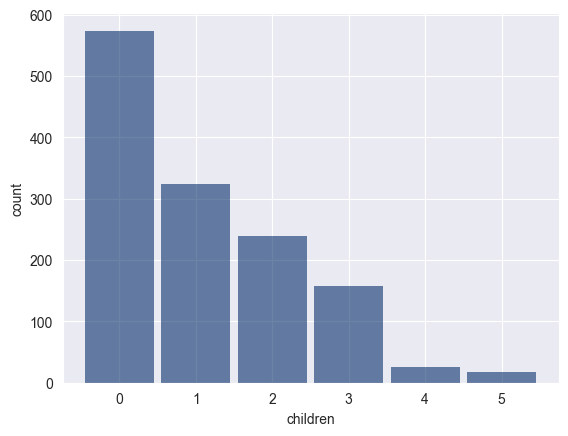

<Figure size 800x600 with 0 Axes>

In [46]:
#Children
create_histogram(all_health_df['children'],"children","count");

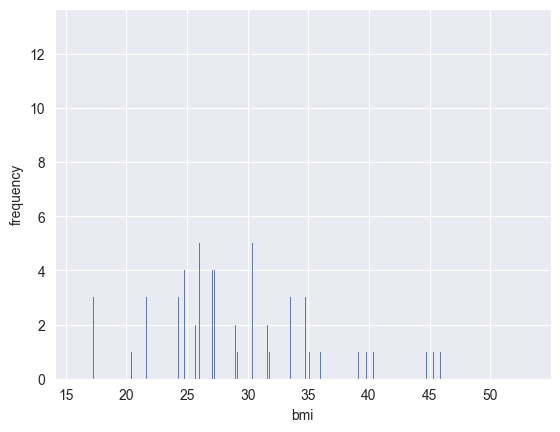

<Figure size 800x600 with 0 Axes>

In [47]:
#bmi
create_histogram(all_health_df['bmi'],"bmi");

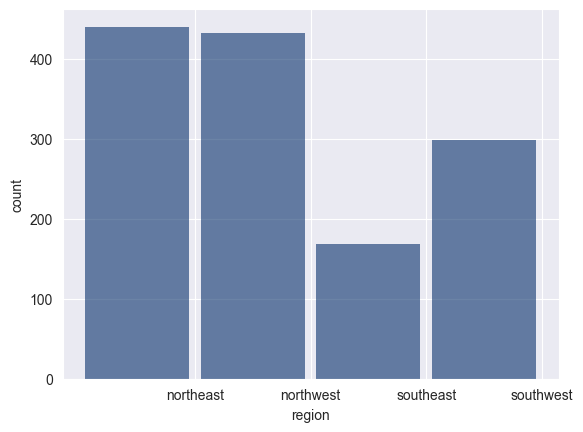

<Figure size 800x600 with 0 Axes>

In [48]:
#region
create_histogram(all_health_df['region'],"region","count");

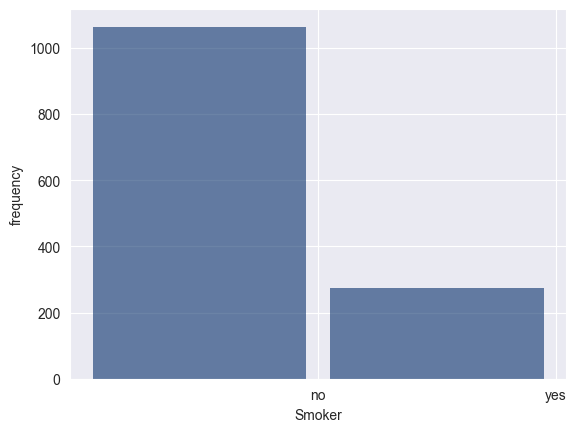

<Figure size 800x600 with 0 Axes>

In [49]:
#smoker
create_histogram(all_health_df['smoker'],"Smoker");

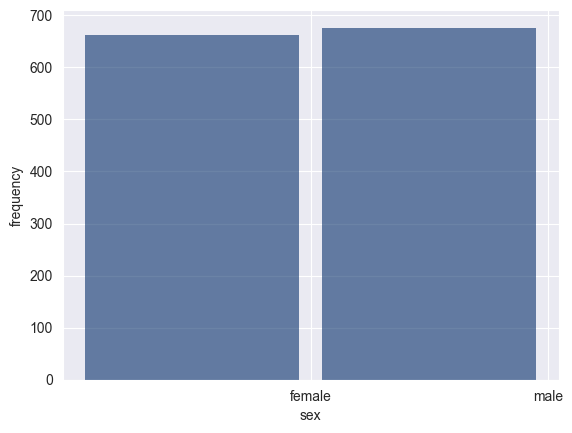

<Figure size 800x600 with 0 Axes>

In [50]:
create_histogram(all_health_df['sex'],"sex");

Identify Outliers via Standard Deviation method

In [51]:
from collections import Counter


def StDev_method (df,n,features):
    """
    Takes a dataframe df of features and returns an index list corresponding to the observations 
    containing more than n outliers according to the standard deviation method.
    """
    outlier_indices = []

    for column in features:
        # calculate the mean and standard deviation of the data frame
        feature_mean = df[column].mean()
        feature_std = df[column].std()

        # calculate the cutoff value, if the value is outside 3 standard deviation
        cut_off = feature_std * 3

        # Determining a list of indices of outliers for feature column        
        outlier_index = df[(df[column] < feature_mean - cut_off) | (df[column] > feature_mean + cut_off)].index
        if len(outlier_index) >0:
            print(f'{column=},{outlier_index=},{len(outlier_index)}')
            print(all_health_df.iloc[outlier_index][column])

        # appending the found outlier indices for column to the list of outlier indices 
        outlier_indices.extend(outlier_index)

    # selecting observations containing more than x outliers
    outlier_indices = Counter(outlier_indices)

    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )

    # Calculate the number of records below and above lower and above bound value respectively
    df1 = df[df[column] > feature_mean + cut_off]
    df2 = df[df[column] < feature_mean - cut_off]
    print('Total number of rows with outliers :', df1.shape[0]+ df2.shape[0])
    print(f'Total number of rows with more than {n} outliers  = {len(multiple_outliers)}, so we can safely say the dataset does not have any major outliers.')
    return multiple_outliers

feature_list = ['age','bmi','charges','children']
# detecting outliers
max_outlier_per_row = 2
Outliers_StDev = StDev_method(all_health_df,max_outlier_per_row,feature_list)

column='bmi',outlier_index=Index([116, 847, 1047, 1317], dtype='int64'),4
116     49.06
847     50.38
1047    52.58
1317    53.13
Name: bmi, dtype: float64
column='charges',outlier_index=Index([34, 543, 577, 819, 1146, 1230, 1300], dtype='int64'),7
34      51194.55914
543     63770.42801
577     58571.07448
819     55135.40209
1146    52590.82939
1230    60021.39897
1300    62592.87309
Name: charges, dtype: float64
column='children',outlier_index=Index([  32,   71,  166,  413,  425,  438,  568,  640,  877,  932,  937,  969,
        984, 1085, 1116, 1130, 1245, 1272],
      dtype='int64'),18
32      5
71      5
166     5
413     5
425     5
438     5
568     5
640     5
877     5
932     5
937     5
969     5
984     5
1085    5
1116    5
1130    5
1245    5
1272    5
Name: children, dtype: int64
Total number of rows with outliers : 18
Total number of rows with more than 2 outliers  = 0, so we can safely say the dataset does not have any major outliers.


Include the other descriptive characteristics about the variables: Mean, Mode, Spread, and Tails (Chapter 2).
Using pg. 29 of your text as an example, compare two scenarios in your data using a PMF. Reminder, this isn’t comparing two variables against each other – it is the same variable, but a different scenario. Almost like a filter. The example in the book is first babies compared to all other babies, it is still the same variable, but breaking the data out based on criteria we are exploring (Chapter 3).

In [52]:
def smoker_pmf(smkr, non_smkr):
    """Create PMF to compare
    """

    smkr_pmf = thinkstats2.Pmf(smkr.charges, label='smoker charges')
    non_smkr_pmf = thinkstats2.Pmf(non_smkr.charges, label='non smoker charges')
    width = 0.45

    thinkplot.PrePlot(2, cols=2)
    thinkplot.Hist(smkr_pmf, align='right', width=width)
    thinkplot.Hist(non_smkr_pmf, align='left', width=width)
    thinkplot.show()

    thinkplot.PrePlot(2)
    thinkplot.SubPlot(2)
    thinkplot.Pmfs([smkr_pmf, non_smkr_pmf])
    thinkplot.show()

In [53]:
smoker_data = all_health_df[all_health_df['smoker'] == 'yes']
non_smoker_data = all_health_df[all_health_df['smoker'] == 'no']

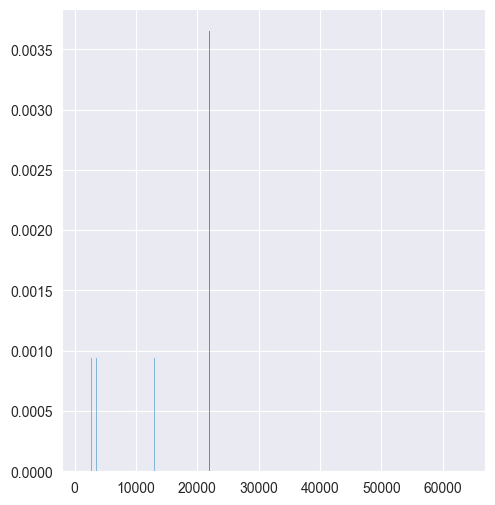

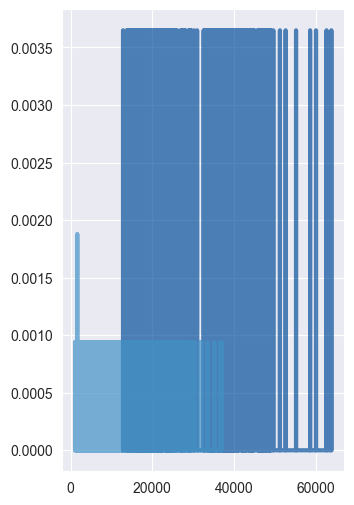

<Figure size 800x600 with 0 Axes>

In [54]:
smoker_pmf(smoker_data,non_smoker_data);

Create 1 CDF with one of your variables, using page 41-44 as your guide, what does this tell you about your variable and how does it address the question you are trying to answer (Chapter 4).

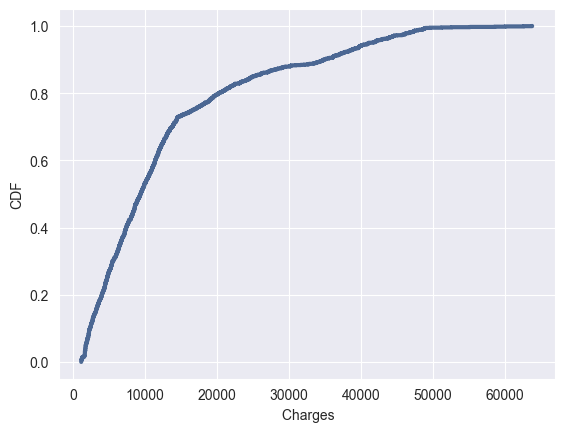

In [55]:
cdf = thinkstats2.Cdf(all_health_df.charges, label='Charges')
thinkplot.Cdf(cdf)
thinkplot.Config(xlabel=' Charges', ylabel='CDF', loc='lower right');

Plot 1 analytical distribution and provide your analysis on how it applies to the dataset you have chosen (Chapter 5).

In [56]:
#create dummies of categorical features so that correlation may be analyzed

categry_df= pd.get_dummies(all_health_df, prefix='gen', columns=['sex'])
categry_df= pd.get_dummies(categry_df, prefix='smok', columns=['smoker'])
categry_df= pd.get_dummies(categry_df, prefix='reg', columns=['region'])
categry_df.drop(columns='city',inplace=True)
categry_df.head(10)

,age,bmi,children,charges,gen_female,gen_male,smok_no,smok_yes,reg_northeast,reg_northwest,reg_southeast,reg_southwest
0,19,27.900,0,16884.92400,True,False,False,True,True,False,False,False
1,18,33.770,1,1725.55230,False,True,True,False,False,True,False,False
2,28,33.000,3,4449.46200,False,True,True,False,False,True,False,False
3,33,22.705,0,21984.47061,False,True,True,False,False,False,True,False
4,32,28.880,0,3866.85520,False,True,True,False,False,False,False,True
5,31,25.740,0,3756.62160,True,False,True,False,False,True,False,False
6,46,33.440,1,8240.58960,True,False,True,False,False,True,False,False
7,37,27.740,3,7281.50560,True,False,True,False,True,False,False,False
8,37,29.830,2,6406.41070,False,True,True,False,False,False,True,False
9,60,25.840,0,28923.13692,True,False,True,False,True,False,False,False


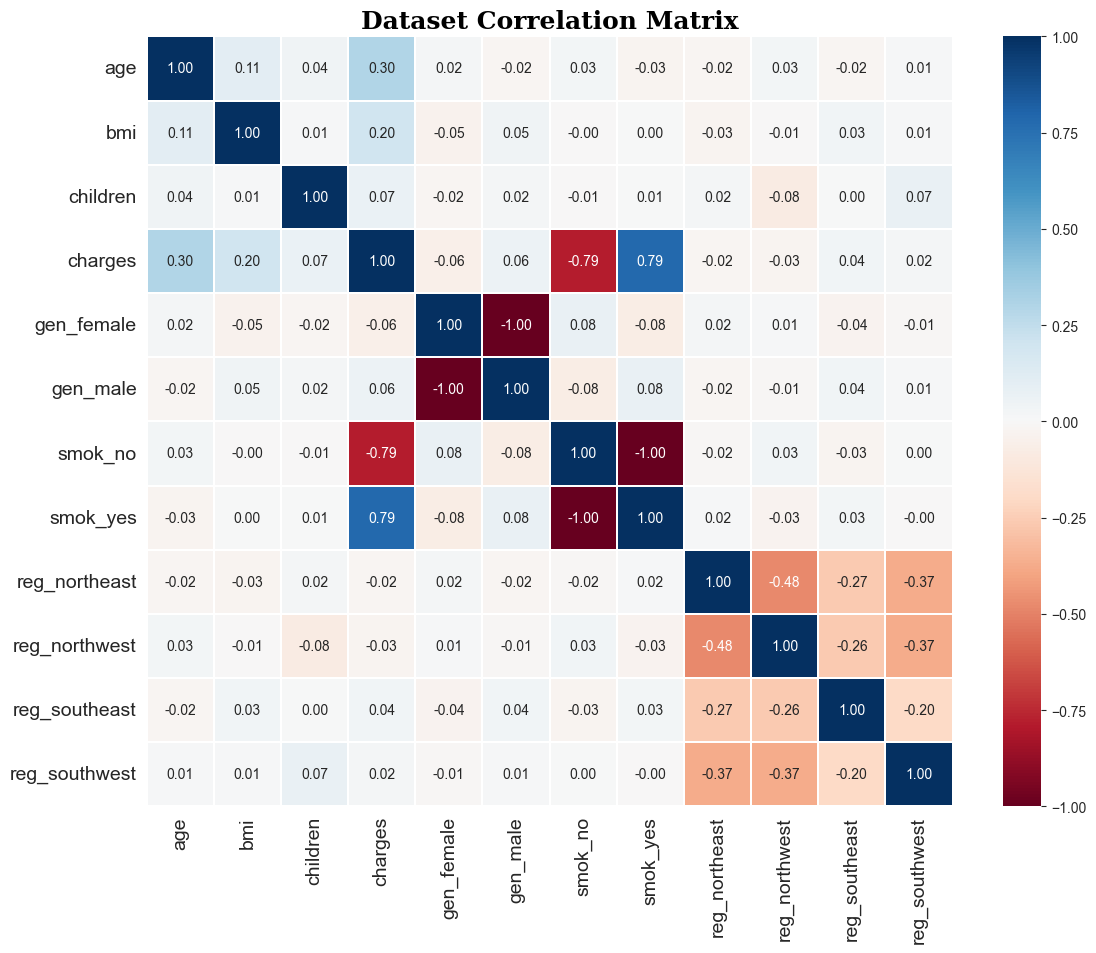

In [57]:
#plot correlation matrix heatmap
fig, ax = plt.subplots(figsize=[13, 10])
sns.heatmap(categry_df.corr(), ax=ax, annot=True, linewidths=0.05, fmt='.2f', cmap="RdBu")
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_title('Dataset Correlation Matrix', fontdict={'family': 'serif', 'color': 'black', 'size': 18, 'weight': 'bold'});


In [58]:
#find which features have significant correlation (-0.5 < coef. > 0.5) 
req_categry_df = np.logical_or(categry_df.corr() > 0.5, categry_df.corr() < -0.5)

req_categry_df.head()
#disregard identity
for i in np.arange(0, len(req_categry_df)):
    req_categry_df.iloc[i,i] = False

#create table of correlation relationships by index values
corr_val = []
for i in np.arange(0, len(req_categry_df.iloc[0, :])):
    for j in np.arange(0, len(req_categry_df.iloc[:, 0])):
        if req_categry_df.iloc[i,j] == True:
            corr_val.append([req_categry_df.index.values[j], req_categry_df.columns.values[i]])

#drop rows in table in which relationships are duplicated in table (x vs. y and y vs. x)            
x = []
for i in np.arange(0,len(corr_val)):
    x.append(str(i))
corr_val = pd.DataFrame(corr_val, columns=["",""], index=x)
del req_categry_df, x
for i in corr_val.index:
    for j in corr_val.index:
        if any(corr_val.index == i) == True:
            a, b = corr_val.loc[i]
            if i != j:
                if np.logical_and((corr_val.loc[j][0] == b) == True, (corr_val.loc[j][1] == a) == True) == True:
                    corr_val.drop(j, inplace=True);
corr_val.reset_index(drop=True, inplace=True)

print('The following features in the data are significantly correlated (-0.5 < coef. > 0.5):\n {}' .format(corr_val))

The following features in the data are significantly correlated (-0.5 < coef. > 0.5):
                        
0   smok_no     charges
1  smok_yes     charges
2  gen_male  gen_female
3  smok_yes     smok_no


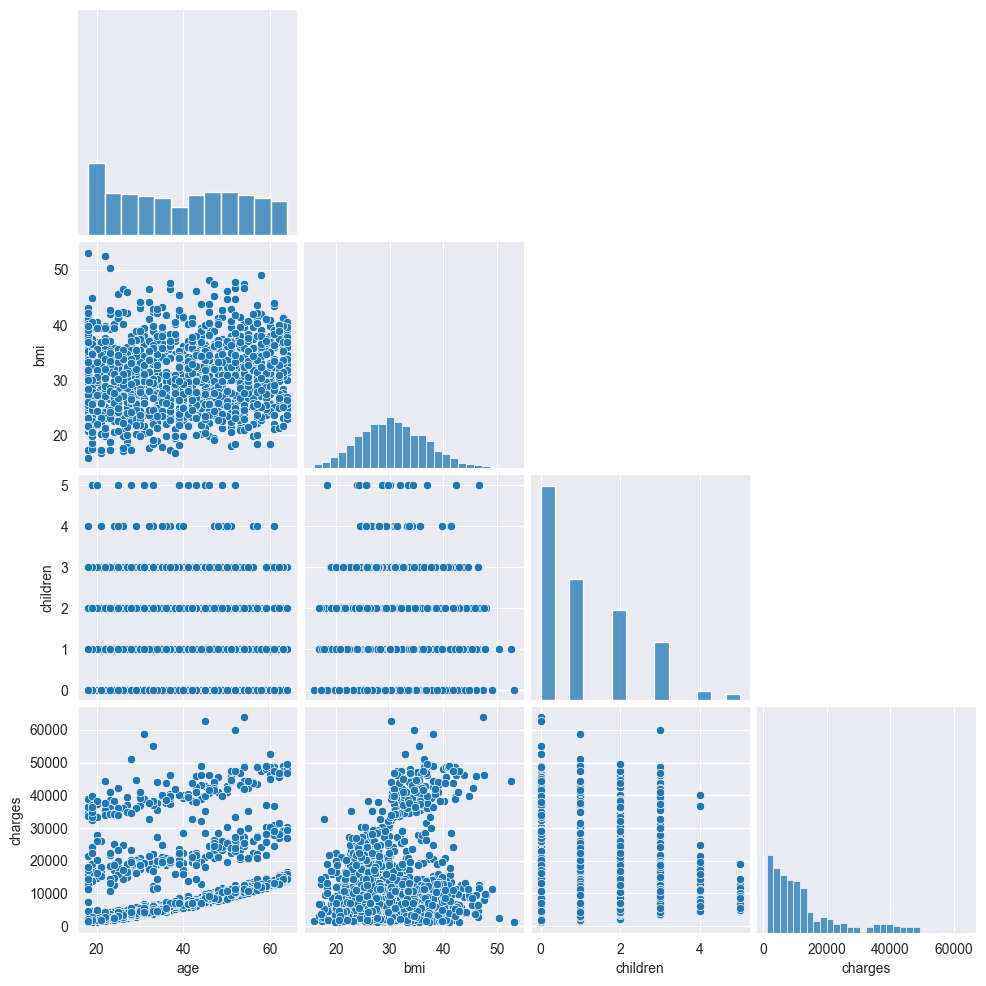

In [59]:
sns.pairplot(all_health_df, corner=True);

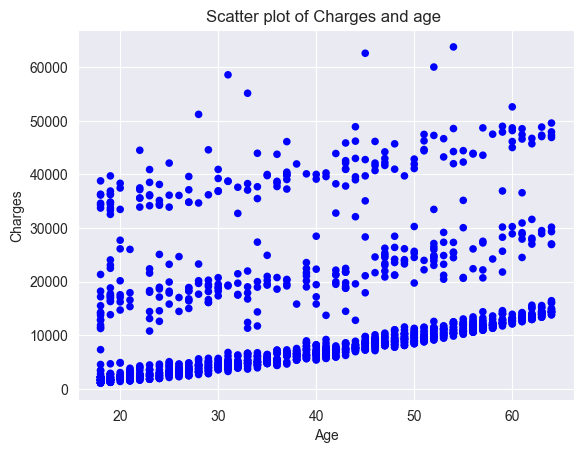

In [60]:
thinkplot.Scatter(all_health_df['age'], all_health_df['charges'], alpha = 1)
thinkplot.Config(title = 'Scatter plot of Charges and age ',
                 xlabel = 'Age',
                 ylabel = 'Charges',
                 legend = False);

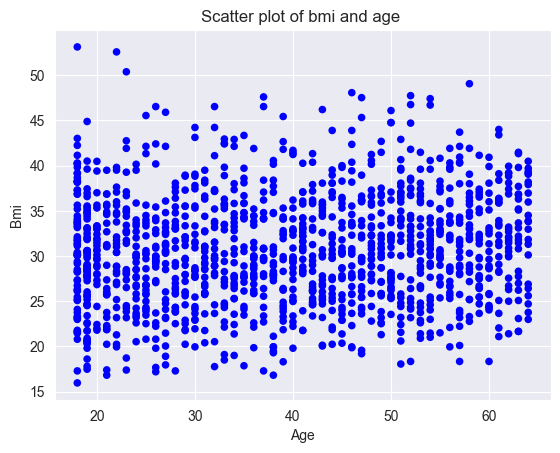

In [61]:
thinkplot.Scatter(all_health_df['age'], all_health_df['bmi'], alpha = 1)
thinkplot.Config(title = 'Scatter plot of bmi and age ',
                 xlabel = 'Age',
                 ylabel = 'Bmi',
                 legend = False);

Conduct a test on your hypothesis using one of the methods covered in Chapter 9.

# <p style="font-size:24px; font-family:'Candara'; font-weight: bold; line-height:1.3">Hypothesis Testing</p>
<p style="font-size:20px; font-family:'Calibri Light'; line-height:1.3; font-weight:bold;">Objective #1: </p>
<p style="font-size:18px; font-family:'Calibri Light'; line-height:1.3;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Are medical claims made by smokers greater than those who don't smoke?</p>

<p style="font-size:18px; font-family:'Calibri Light'; line-height:1.3;">H$_0$: $\mu_1$ $\leq$ $\mu_2$<br>
H$_a$: $\mu_1$ > $\mu_2$<br><br></p>
<p style="font-size:18px; font-family:'Calibri Light'; line-height:1.3; font-weight:bold;">Where:</p>
<p style="font-size:18px; font-family:'Calibri Light'; line-height:1.3;">$\mu_1$ = Claims by smokers<br>
$\mu_2$ = Claims by non-smokers<br><br>
$\alpha$ = 0.05 &nbsp;&nbsp;&nbsp;&nbsp;(95% Confidence Interval)</p>

In [62]:
def run_hypothesis_test(data, iters=1000):
    """Test the difference in means between Alaska Airlines and other airlines
    """

    # test the difference in means
    ht = hypothesis.DiffMeansPermute(data)
    p_value = ht.PValue(iters=iters)
    print('\nmeans permute two-sided')
    hypothesis.PrintTest(p_value, ht)

    ht.PlotCdf()
  

    # test the difference in means one-sided
    ht = hypothesis.DiffMeansOneSided(data)
    p_value = ht.PValue(iters=iters)
    print('\nmeans permute one-sided')
    hypothesis.PrintTest(p_value, ht)

    # test the difference in std
    ht = hypothesis.DiffStdPermute(data)
    p_value = ht.PValue(iters=iters)
    print('\nstd permute one-sided')
    hypothesis.PrintTest(p_value, ht)

0 1000

means permute two-sided
p-value = 0.0
actual = 23615.963533676637
ts max = 3263.261602219054
0 1000

means permute one-sided
p-value = 0.0
actual = 23615.963533676637
ts max = 2895.1017710675733
0 1000

std permute one-sided
p-value = 0.0
actual = 5529.502176241819
ts max = 2524.594327813067


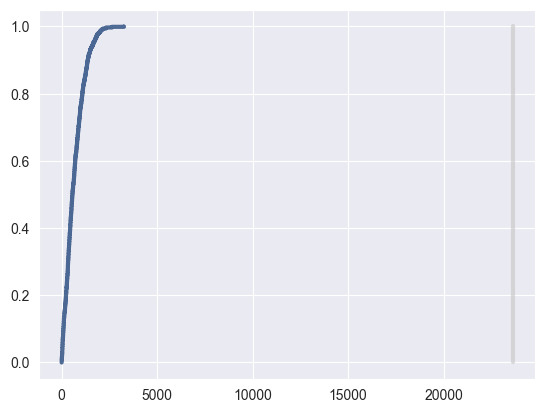

In [63]:
hypothesisTestData= smoker_data.charges.values, non_smoker_data.charges.values
run_hypothesis_test(hypothesisTestData)

Conclusion:
The p-value is near to 0 , which means it is plausible that the observed difference is just the result of random sampling, and might not be generally true in the population.
Reject the Null Hypothesis.

# <p style="font-size:24px; font-family:'Candara'; font-weight: bold; line-height:1.3">Hypothesis Testing</p>
<p style="font-size:20px; font-family:'Calibri Light'; line-height:1.3; font-weight:bold;">Objective #2: </p>
<p style="font-size:18px; font-family:'Calibri Light'; line-height:1.3;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Is BMI of smokers greater than those who don't smoke?</p>

<p style="font-size:18px; font-family:'Calibri Light'; line-height:1.3;">H$_0$: $\mu_1$ $\leq$ $\mu_2$<br>
H$_a$: $\mu_1$ > $\mu_2$<br><br></p>
<p style="font-size:18px; font-family:'Calibri Light'; line-height:1.3; font-weight:bold;">Where:</p>
<p style="font-size:18px; font-family:'Calibri Light'; line-height:1.3;">$\mu_1$ = bmi by smokers<br>
$\mu_2$ = bmi by non-smokers<br><br>
$\alpha$ = 0.05 &nbsp;&nbsp;&nbsp;&nbsp;(95% Confidence Interval)</p>

891 1000

means permute two-sided
p-value = 0.891
actual = 0.05665379232753409
ts max = 1.4330402420284258
456 1000

means permute one-sided
p-value = 0.456
actual = 0.05665379232753409
ts max = 1.3021251920860522
172 1000

std permute one-sided
p-value = 0.172
actual = 0.26683215652024117
ts max = 1.0362670517620627


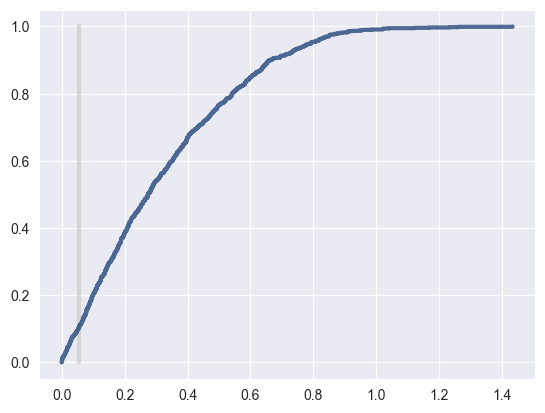

In [64]:

hypothesisTestData= smoker_data.bmi.values, non_smoker_data.bmi.values

run_hypothesis_test(hypothesisTestData)

p-value of .44 is significant than alpha of .05 and hence Null hypothesis cannot be rejected. In other words, the claims made by smokers is less than or equal to that of non-smokers.

In [65]:
def linear_reg_test(all_data,x_data,y_data):
    """Plots a scatter plot and fitted curve.
    """
    sample = thinkstats2.SampleRows(all_data, 1000)
    inter, slope = thinkstats2.LeastSquares(x_data, y_data)
    fit_xs, fit_ys = thinkstats2.FitLine(x_data, inter, slope)

    thinkplot.Scatter(x_data, y_data, color='gray', alpha=0.1)
    thinkplot.Plot(fit_xs, fit_ys, color='white', linewidth=3)
    thinkplot.Plot(fit_xs, fit_ys, color='blue', linewidth=2)
    thinkplot.show(root='chargesbmi linear',
                   xlabel='bmi',
                   ylabel='charges',
                   #                   axis=[10, 45, 0, 15],
                   legend=False)

    formula = 'charges ~ bmi'
    model = smf.ols(formula, data=sample)
    results = model.fit()
    regression.SummarizeResults(results)

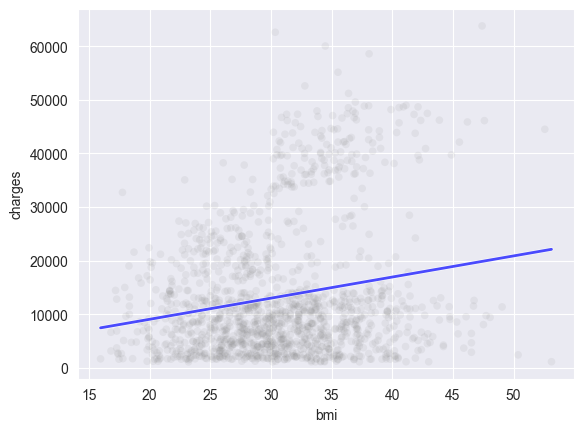

Intercept   -568   (0.773)
bmi   458   (6.72e-13)
R^2 0.05044
Std(ys) 1.235e+04
Std(res) 1.204e+04


<Figure size 800x600 with 0 Axes>

In [66]:
bmi_df,charges_df = all_health_df['bmi'],all_health_df['charges']
linear_reg_test(all_health_df,bmi_df,charges_df)

In [67]:
formula = 'charges ~ bmi + children + age'
model = smf.ols(formula, data = all_health_df)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     60.69
Date:                Sat, 11 Jan 2025   Prob (F-statistic):           8.80e-37
Time:                        19:29:29   Log-Likelihood:                -14392.
No. Observations:                1338   AIC:                         2.879e+04
Df Residuals:                    1334   BIC:                         2.881e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -6916.2433   1757.480     -3.935      0.000   -1.04e+04   -3468.518
bmi          332.0834     51.310      6.472      0.000     231.425     432.741
children     542.8647    258.241      2.102      0.036      36.261    1049.468
age          239.9945     22.289     10.767      0.000     196.269     283.720
==============================================================================
Omnibus:                      325.395   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              603.372
Skew:                           1.520   Prob(JB):                    9.54e-132
Kurtosis:                       4.255   Cond. No.                         290.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""